In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from yahoofinancials import YahooFinancials
from finta import TA
import gym_anytrading
from gym_anytrading.envs import StocksEnv

from datetime import date
from datetime import timedelta

from keras.models import Sequential
from keras.layers import LSTM, Dense
import random

2023-05-12 19:46:51.074059: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 19:46:55.718146: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
symbol = 'TSLA'

years = 2

years = 365*years

endDate = date.today()

startDate = endDate - timedelta(years)

stock = YahooFinancials(symbol)

stock_price_data = pd.DataFrame(stock.get_historical_price_data(str(startDate), str(endDate), 'daily')[symbol]['prices'])

stock_price_data.head()


,date,high,low,open,close,volume,adjclose,formatted_date
0,1620826200,206.803329,195.589996,200.830002,196.630005,101470800,196.630005,2021-05-12
1,1620912600,202.153336,186.550003,200.513336,190.563339,132554700,190.563339,2021-05-13
2,1620999000,197.623337,190.153336,194.470001,196.580002,100112700,196.580002,2021-05-14
3,1621258200,196.576660,187.066666,191.850006,192.276672,97171200,192.276672,2021-05-17
4,1621344600,198.750000,187.793335,189.333328,192.623337,110491800,192.623337,2021-05-18


In [3]:
stock_price_data.drop(columns=['date'], inplace=True)

In [4]:
stock_price_data.dropna(inplace=True)

In [5]:
stock_price_data.rename(columns={'formatted_date':'date'}, inplace=True)
stock_price_data['date'] = pd.to_datetime(stock_price_data['date'])
stock_price_data.set_index('date', inplace=True)

In [6]:
stock_price_data.columns = [x.capitalize() for x in stock_price_data.columns]

In [7]:
stock_ind_data = stock_price_data.copy()

In [8]:
stock_ind_data

,High,Low,Open,Close,Volume,Adjclose
date,,,,,,
2021-05-12,206.803329,195.589996,200.830002,196.630005,101470800,196.630005
2021-05-13,202.153336,186.550003,200.513336,190.563339,132554700,190.563339
2021-05-14,197.623337,190.153336,194.470001,196.580002,100112700,196.580002
2021-05-17,196.576660,187.066666,191.850006,192.276672,97171200,192.276672
2021-05-18,198.750000,187.793335,189.333328,192.623337,110491800,192.623337
...,...,...,...,...,...,...
2023-05-05,170.789993,163.509995,163.970001,170.059998,107440900,170.059998
2023-05-08,173.800003,169.190002,173.720001,171.789993,112249400,171.789993
2023-05-09,169.820007,166.559998,168.949997,169.149994,88965000,169.149994


# Adding Indicators

In [9]:
stock_ind_data['RSI'] = TA.RSI(stock_ind_data)
stock_ind_data['MACD'] = TA.MACD(stock_ind_data)['MACD']
stock_ind_data['MACD_SIGNAL'] = TA.MACD(stock_ind_data)['SIGNAL']
stock_ind_data['OBV'] = TA.OBV(stock_ind_data)
stock_ind_data['STOCH'] = TA.STOCH(stock_price_data)
stock_ind_data['STOCHD'] = TA.STOCHD(stock_price_data)
stock_ind_data.dropna(inplace=True)
stock_ind_data.head()

,High,Low,Open,Close,Volume,Adjclose,RSI,MACD,MACD_SIGNAL,OBV,STOCH,STOCHD
date,,,,,,,,,,,,
2021-06-03,201.516663,190.406662,200.600006,190.946671,90335700,190.946671,40.441413,0.918262,1.224331,-221508600.0,29.184100,60.534944
2021-06-04,200.203339,192.399994,193.236664,199.683334,72110700,199.683334,50.960843,0.767312,1.130821,-149397900.0,58.763144,51.186874
2021-06-07,203.333328,194.293335,197.276672,201.710007,67631100,201.710007,53.033186,0.770071,1.057348,-81766800.0,65.624692,51.190645
2021-06-08,207.696671,198.500000,207.669998,201.196671,78160200,201.196671,52.428831,0.729894,0.990899,-159927000.0,63.886729,62.758188
2021-06-09,203.929993,199.210007,200.723328,199.593338,49753800,199.593338,50.493369,0.585608,0.908895,-209680800.0,42.947938,57.486453


# Custom Environment with indicators

In [10]:
def process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['RSI', 'MACD', 'MACD_SIGNAL', 'OBV', 'STOCH','STOCHD']]
    return prices, signal_features

class MyStocksEnv(StocksEnv):
    _process_data = process_data

In [11]:
env = MyStocksEnv(df=stock_ind_data, frame_bound=(10, stock_ind_data.shape[0]-365), window_size=10)

In [12]:
for i in range(100):
    done = False
    r = 0
    state = env.reset()
    while not done:
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        r+=reward
        if done: 
            print('Episode: {}, info: {}'.format(i, info))
            break

        

Episode: 0, info: {'total_reward': 100.84335327148438, 'total_profit': 0.9197692270484599, 'position': 0}
Episode: 1, info: {'total_reward': -56.72010803222656, 'total_profit': 0.5295681746875222, 'position': 1}
Episode: 2, info: {'total_reward': 97.75338745117188, 'total_profit': 0.9257949164885142, 'position': 0}
Episode: 3, info: {'total_reward': 67.51002502441406, 'total_profit': 0.8638559968265235, 'position': 1}
Episode: 4, info: {'total_reward': 37.370086669921875, 'total_profit': 0.8126667542257301, 'position': 1}
Episode: 5, info: {'total_reward': 42.70664978027344, 'total_profit': 0.7946033689563591, 'position': 1}
Episode: 6, info: {'total_reward': 91.12995910644531, 'total_profit': 0.9148325455415032, 'position': 1}
Episode: 7, info: {'total_reward': 178.82334899902344, 'total_profit': 1.3328190714586532, 'position': 1}
Episode: 8, info: {'total_reward': 81.23330688476562, 'total_profit': 0.8692893369380913, 'position': 0}
Episode: 9, info: {'total_reward': 102.786666870117

In [13]:
class SumTree(object):
    data_pointer = 0
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2*capacity-1)
        self.data = np.zeros(capacity, dtype=object)
        self.length = 0
        
    def update(self, tree_index, priority):
        change = priority-self.tree[tree_index]
        self.tree[tree_index] = priority
        
        while tree_index>0:
            tree_index = (tree_index-1)//2
            self.tree[(tree_index)] += change
    
    def add(self, priority, data):
        tree_index = self.data_pointer+self.capacity-1
        self.data[self.data_pointer] = data
        self.update(tree_index, priority)
        self.data_pointer+=1
        if(self.data_pointer>=self.capacity):
            self.data_pointer=0
        else: 
            self.length+=1
    
    def get_leaf(self, v):
        pi = 0
        while True:
            lci = pi*2+1
            rci = lci+1
            
            if lci>=self.capacity:
                leaf_index = pi
                break
            else:
                if v<=self.tree[lci]:
                    pi = lci
                else:
                    v-=self.tree[lci]
                    pi = rci
        data_index = leaf_index-self.capacity+1
        return leaf_index, self.tree[leaf_index], self.data[data_index]
    
    @property
    def total_priority(self):
        return self.tree[0]

In [14]:
class Memory(object):
    e = 0.04
    a = 0.6
    b = 0.4
    b_increment = 0.001
    absolute_error_upper = 1   
    
    def __init__(self, capacity):
        self.tree = SumTree(capacity)
        self.capacity=capacity
        self.memories_n = 0
    
    def store(self, experience):
        max_priority = np.max(self.tree.tree[-self.tree.capacity:])
        if max_priority == 0:
            max_priority = self.absolute_error_upper
        self.tree.add(max_priority, experience)
        self.memories_n+=1
    
    def sample(self, n):
        minibatch = []
        b_idx = np.empty((n,), dtype=np.int32)
        priority_segment = self.tree.total_priority/n
        for i in range(n):
            A,B = priority_segment*i, priority_segment*(i+1)
            value = np.random.uniform(A,B)
            index, priority, data = self.tree.get_leaf(value)
            b_idx[i] = index
            minibatch.append(list(data))
        return b_idx, minibatch
    
    def batch_update(self, tree_idx, abs_error):
        abs_error+=self.e
        clipped_error = np.minimum(abs_error, self.absolute_error_upper)
        ps = np.power(clipped_error, self.a)
        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)

In [15]:
class Actor:

    def __init__(self,  env, batch_size, learner):
        self.env = env
        self.state = np.array(self.env.reset())
        self.learner = learner
        self.model = self.build_model()
        self.discount_factor = 0.92
        self.local_memory = []
        self.replay_memory = learner.replay_memory
        self.batch_size = batch_size

    def env_reset(self):
        self.state = (self.env.reset())
        self.local_memory = []
        


    def build_model(self):
        model = Sequential()
        model.add(CuDNNLSTM(300, input_shape=(self.state.shape[0], self.state.shape[1]), return_sequences=True))
        model.add(CuDNNLSTM(200))
        model.add(Dense(self.learner.action_shape, activation='softmax'))
        
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
        return model
    
    def update_weights(self):
        self.model.set_weights(self.learner.model.get_weights())
    
    def get_action(self, state):
        state = np.array(state).reshape(self.learner.state_shape)
        # print(state.shape)
        action = np.argmax(self.model.predict(state)[0])
        return action
    
    def compute_TD(self, minibatch):
        curr_state = []
        next_state = []
        actions = []
        rewards = []
        done = []
        qValues = []

        for i in range(self.batch_size):
            curr_state.append(minibatch[i][0].reshape(self.learner.state_shape))
            actions.append(minibatch[i][1])
            rewards.append(minibatch[i][2])
            next_state.append(minibatch[i][3].reshape(self.learner.state_shape))
            done.append(minibatch[i][4])
            qValues.append(self.model.predict(curr_state[i])[0])
            qValue_ns = np.amax(self.model.predict(next_state[i])[0])
            if done[i]:
                qValues[i][actions[i]] = rewards[i]
            else:
                qValues[i][actions[i]] = rewards[i] + self.discount_factor*qValue_ns
        
        qValues = np.array(qValues)
        curr_state = np.array(curr_state)
        actions = np.array(actions)

        pred_qValues = np.array([self.model.predict(x)[0] for x in curr_state])
        indices = np.arange(self.batch_size)
        abs_error = np.abs(qValues[indices, actions]-pred_qValues[indices, actions])

        return abs_error
        

    def perform_action(self):
        action = self.get_action(self.state)
        next_state, reward, done, info = self.env.step(action)
        next_state = np.array(next_state)
        self.local_memory.append([self.state, action, reward, next_state, done])
        if len(self.local_memory) >= self.batch_size:
            minibatch = self.local_memory[-self.batch_size:]
            self.local_memory.pop(0)
            TD = self.compute_TD(minibatch)
            TD += self.replay_memory.e
            clipped_error = np.minimum(TD, self.replay_memory.absolute_error_upper)
            priority = np.power(clipped_error, self.replay_memory.a)
            for data, p in zip(minibatch, clipped_error):
                self.replay_memory.tree.add(p, data)
                self.replay_memory.memories_n+=1
        self.state = next_state



In [16]:

class Learner:
    
    def __init__(self, state_shape, action_shape, memory_size, batch_size=24, ddqn_flag=False):
        self.ddqn = ddqn_flag
        self.action_shape = action_shape
        #hyper parameters
        self.discount_factor = 0.9
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.04
        self.batch_size = batch_size
        self.train_start = 10000
        self.dueling_option = 'avg'
        self.memory_size = memory_size
        self.memories_n = 0

        self.state_shape = (1, state_shape[0], state_shape[1])
        
        #memory
        self.replay_memory = Memory(self.memory_size)
        
        #model
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.target_model.set_weights(self.model.get_weights())     
    
    def build_model(self):
        
        model = Sequential()
        model.add(LSTM(300, input_shape=(self.state_shape[1], self.state_shape[2]), return_sequences=True, activation='relu'))
        model.add(LSTM(200, activation='relu'))
        model.add(Dense(self.action_shape, activation='softmax'))
        
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
        return model
        
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_shape)
        else:
            return np.argmax(self.model.predict(state.reshape(self.state_shape))[0])
    
    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            print('hi#####helloooooooooooooooo')
            
    def get_target_q_value(self, next_state):
        
        if self.ddqn:
            action = np.argmax(self.model.predict(next_state)[0])
            max_q_value = self.target_model.predict(next_state)[0][action]
            
        else:
            max_q_value = np.amax(self.target_model.predict(next_state)[0])
        return max_q_value
    
    def update_target_model(self, tau=0.003):
        if self.ddqn:
            weights = self.model.get_weights()
            target_weights = self.target_model.get_weights()
            
            for i in range(len(target_weights)):
                target_weights[i] = weights[i]*tau + target_weights[i]*(1-tau)
            self.target_model.set_weights(target_weights)
        else:
            self.target_model.set_weights(self.model.get_weights())
    
    def experience_replay(self):
        if self.replay_memory.memories_n < self.replay_memory.capacity:
            return
        
        tree_idx, minibatch = self.replay_memory.sample(self.batch_size)
        current_state = np.zeros((self.batch_size, self.state_shape[1], self.state_shape[2]))
        next_state = np.zeros((self.batch_size, self.state_shape[1], self.state_shape[2]))
        actions = np.zeros(self.batch_size, dtype=int)
        rewards = np.zeros(self.batch_size)
        done = np.zeros(self.batch_size, dtype=bool)
        qValues = np.zeros((self.batch_size, self.action_shape))
        for i in range(self.batch_size):
            current_state[i] = minibatch[i][0].reshape((self.state_shape[1], self.state_shape[2]))
            next_state[i] = minibatch[i][3].reshape((self.state_shape[1], self.state_shape[2]))
            actions[i] = minibatch[i][1]
            rewards[i] = minibatch[i][2]
            done[i] = minibatch[i][4]

            qValues[i] = self.model.predict(current_state[i].reshape(self.state_shape))
            qValue_ns = self.get_target_q_value(next_state[i].reshape(self.state_shape))

            if done[i]:
                qValues[i][actions[i]] = rewards[i]
            else:
                qValues[i][actions[i]] = rewards[i] + self.discount_factor*qValue_ns
        
        #calculating TD
        pred_qValues = np.array(self.model.predict(current_state))
        indices = np.arange(self.batch_size)
        absolute_errors = np.abs(qValues[indices, actions]-pred_qValues[indices, actions])
        self.replay_memory.batch_update(tree_idx, absolute_errors)

        #train
        self.model.fit(current_state, qValues, batch_size=self.batch_size, epochs=1, verbose=0)
        self.update_epsilon()
        
                    
        

In [17]:
timesteps = 10
test_n = 30
env = MyStocksEnv(df=stock_ind_data, frame_bound=(timesteps, stock_ind_data.shape[0]-test_n), window_size=timesteps)


In [18]:
def build_actors(df, batch_size, learner, test_n, n):
    actors = []
    for i in range(n):
        env = MyStocksEnv(df=stock_ind_data, frame_bound=(batch_size, stock_ind_data.shape[0]-test_n), window_size=batch_size)
        actors.append(Actor(env, batch_size=batch_size, learner=learner))
    return actors

In [19]:
episodes = 10
state = np.array(env.reset())
learner = Learner(state_shape = state.shape, action_shape = env.action_space.n, memory_size=100, ddqn_flag=True)
actors_n = 4
actors = build_actors(df=stock_ind_data, batch_size=timesteps, learner=learner, n=actors_n, test_n=test_n)

infos = {}

for e in range(episodes):
    done = False
    r = 0
    state = np.array(env.reset())
    while not done:
        for actor in actors:
            actor.perform_action()
        action = learner.get_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = np.array(next_state)
        learner.experience_replay()
        for actor in actors:
            actor.update_weights()
        if done:
            for actor in actors:
                actor.env_reset()
            infos[e]=info
            print("Episode: {}, Info: ()".format(e, info))
            break
        state = next_state
        
            


2023-05-12 19:50:14.760914: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-12 19:50:18.529248: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-12 19:50:18.529565: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

1/1 [==============================] - 0s 169ms/step


2023-05-12 19:50:57.136289: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x24277980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-12 19:50:57.136343: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2023-05-12 19:50:57.815725: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-12 19:51:00.096959: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


env.render_all()
plt.show()

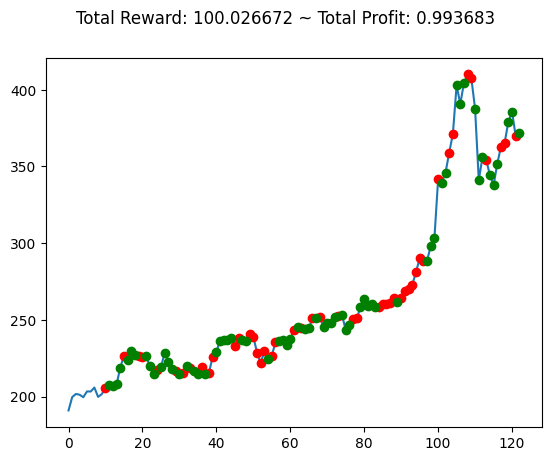

In [25]:
test_env = MyStocksEnv(df=stock_ind_data, frame_bound=(stock_ind_data.shape[0]-test_n, stock_ind_data.shape[0]), window_size=timesteps)

1/1 [==============================] - 0s 14ms/step
info: {'total_reward': -50.89338684082031, 'total_profit': 0.2341704610199991, 'position': 1}


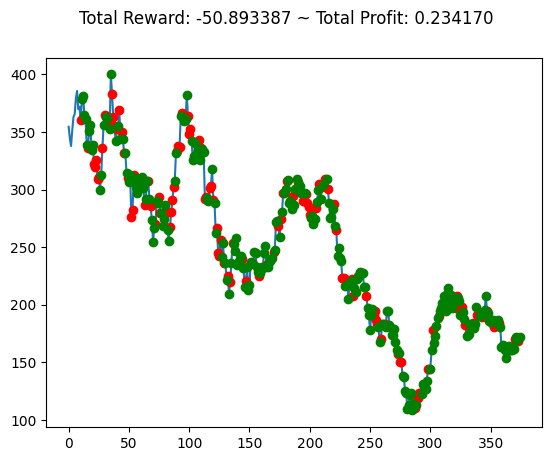

In [28]:
state = np.array(test_env.reset())
done = False
while not done:
    action = learner.get_action(state)
    next_state, reward, done, info = test_env.step(action)
    next_state = np.array(next_state)
    r+=reward
    if done: 
        print('info: {}'.format(info))
        break
    state = next_state
test_env.render_all()
plt.show()